In [1]:
import numpy as np

In [2]:
from bokeh.plotting import figure, output_notebook, show

In [3]:
# adapted from here: http://www.atm.damtp.cam.ac.uk/people/tjf37/streamplot.py
# using until Bokeh has its own streamline integrator built in
def streamlines(x, y, u, v, density=1):
    '''Returns streamlines of a vector flow.

    * x and y are 1d arrays defining an *evenly spaced* grid.
    * u and v are 2d arrays (shape [y,x]) giving velocities.
    * density controls the closeness of the streamlines. For different
      densities in each direction, use a tuple or list [densityx, densityy].

     '''

    ## Set up some constants - size of the grid used.
    NGX = len(x)
    NGY = len(y)

    ## Constants used to convert between grid index coords and user coords.
    DX = x[1]-x[0]
    DY = y[1]-y[0]
    XOFF = x[0]
    YOFF = y[0]

    ## Now rescale velocity onto axes-coordinates
    u = u / (x[-1]-x[0])
    v = v / (y[-1]-y[0])
    speed = np.sqrt(u*u+v*v)
    ## s (path length) will now be in axes-coordinates, but we must
    ## rescale u for integrations.
    u *= NGX
    v *= NGY
    ## Now u and v in grid-coordinates.

    NBX = int(30*density)
    NBY = int(30*density)
    blank = np.zeros((NBY,NBX))

    bx_spacing = NGX/float(NBX-1)
    by_spacing = NGY/float(NBY-1)

    def blank_pos(xi, yi):
        return int((xi / bx_spacing) + 0.5), \
               int((yi / by_spacing) + 0.5)

    def value_at(a, xi, yi):
        if type(xi) == np.ndarray:
            x = xi.astype(np.int)
            y = yi.astype(np.int)
        else:
            x = np.int(xi)
            y = np.int(yi)
        a00 = a[y,x]
        a01 = a[y,x+1]
        a10 = a[y+1,x]
        a11 = a[y+1,x+1]
        xt = xi - x
        yt = yi - y
        a0 = a00*(1-xt) + a01*xt
        a1 = a10*(1-xt) + a11*xt
        return a0*(1-yt) + a1*yt

    def rk4_integrate(x0, y0):
        ## This function does RK4 forward and back trajectories from
        ## the initial conditions, with the odd 'blank array'
        ## termination conditions. TODO tidy the integration loops.

        def f(xi, yi):
            dt_ds = 1./value_at(speed, xi, yi)
            ui = value_at(u, xi, yi)
            vi = value_at(v, xi, yi)
            return ui*dt_ds, vi*dt_ds

        def g(xi, yi):
            dt_ds = 1./value_at(speed, xi, yi)
            ui = value_at(u, xi, yi)
            vi = value_at(v, xi, yi)
            return -ui*dt_ds, -vi*dt_ds

        check = lambda xi, yi: xi>=0 and xi<NGX-1 and yi>=0 and yi<NGY-1

        bx_changes = []
        by_changes = []

        ## Integrator function
        def rk4(x0, y0, f):
            ds = 0.01 #min(1./NGX, 1./NGY, 0.01)
            stotal = 0
            xi = x0
            yi = y0
            xb, yb = blank_pos(xi, yi)
            xf_traj = []
            yf_traj = []
            while check(xi, yi):
                # Time step. First save the point.
                xf_traj.append(xi)
                yf_traj.append(yi)
                # Next, advance one using RK4
                try:
                    k1x, k1y = f(xi, yi)
                    k2x, k2y = f(xi + .5*ds*k1x, yi + .5*ds*k1y)
                    k3x, k3y = f(xi + .5*ds*k2x, yi + .5*ds*k2y)
                    k4x, k4y = f(xi + ds*k3x, yi + ds*k3y)
                except IndexError:
                    # Out of the domain on one of the intermediate steps
                    break
                xi += ds*(k1x+2*k2x+2*k3x+k4x) / 6.
                yi += ds*(k1y+2*k2y+2*k3y+k4y) / 6.
                # Final position might be out of the domain
                if not check(xi, yi): break
                stotal += ds
                # Next, if s gets to thres, check blank.
                new_xb, new_yb = blank_pos(xi, yi)
                if new_xb != xb or new_yb != yb:
                    # New square, so check and colour. Quit if required.
                    if blank[new_yb,new_xb] == 0:
                        blank[new_yb,new_xb] = 1
                        bx_changes.append(new_xb)
                        by_changes.append(new_yb)
                        xb = new_xb
                        yb = new_yb
                    else:
                        break
                if stotal > 2:
                    break
            return stotal, xf_traj, yf_traj

        integrator = rk4

        sf, xf_traj, yf_traj = integrator(x0, y0, f)
        sb, xb_traj, yb_traj = integrator(x0, y0, g)
        stotal = sf + sb
        x_traj = xb_traj[::-1] + xf_traj[1:]
        y_traj = yb_traj[::-1] + yf_traj[1:]

        ## Tests to check length of traj. Remember, s in units of axes.
        if len(x_traj) < 1: return None
        if stotal > .2:
            initxb, inityb = blank_pos(x0, y0)
            blank[inityb, initxb] = 1
            return x_traj, y_traj
        else:
            for xb, yb in zip(bx_changes, by_changes):
                blank[yb, xb] = 0
            return None

    ## A quick function for integrating trajectories if blank==0.
    trajectories = []
    def traj(xb, yb):
        if xb < 0 or xb >= NBX or yb < 0 or yb >= NBY:
            return
        if blank[yb, xb] == 0:
            t = rk4_integrate(xb*bx_spacing, yb*by_spacing)
            if t != None:
                trajectories.append(t)

    ## Now we build up the trajectory set. I've found it best to look
    ## for blank==0 along the edges first, and work inwards.
    for indent in list(range((max(NBX,NBY))//2)):
        for xi in list(range(max(NBX,NBY)-2*indent)):
            traj(xi+indent, indent)
            traj(xi+indent, NBY-1-indent)
            traj(indent, xi+indent)
            traj(NBX-1-indent, xi+indent)

    xs = [np.array(t[0])*DX+XOFF for t in trajectories]
    ys = [np.array(t[1])*DY+YOFF for t in trajectories]

    return xs, ys

In [4]:
xx = np.linspace(-3, 3, 100)
yy = np.linspace(-3, 3, 100)

Y, X = np.meshgrid(xx, yy)
U = -1 - X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U*U + V*V)
theta = np.arctan(V/U)

x0 = X[::2, ::2].flatten()
y0 = Y[::2, ::2].flatten()
length = speed[::2, ::2].flatten()/40
angle = theta[::2, ::2].flatten()
x1 = x0 + length * np.cos(angle)
y1 = y0 + length * np.sin(angle)

In [5]:
xs, ys = streamlines(xx, yy, U.T, V.T, density=2)

In [6]:
cm = np.array(["#C7E9B4", "#7FCDBB", "#41B6C4", "#1D91C0", "#225EA8", "#0C2C84"])
ix = ((length-length.min())/(length.max()-length.min())*5).astype('int')
colors = cm[ix]


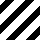
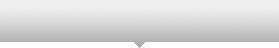
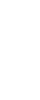
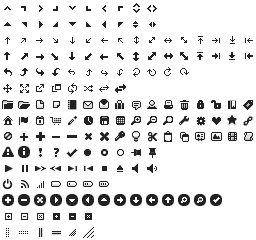
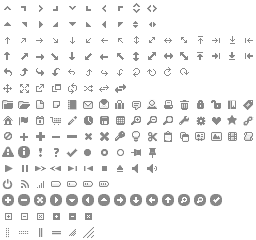
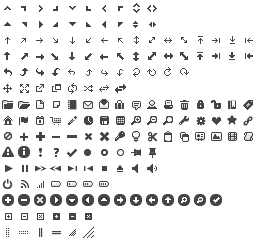
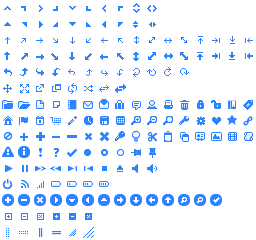
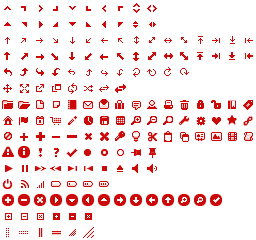
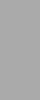
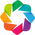
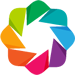
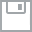
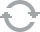
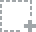
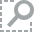
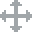
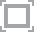
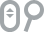

In [7]:
output_notebook()

In [8]:
p = figure()
p.segment(x0, y0, x1, y1, line_color=colors, line_width=2,name="vector example")
show(p)

In [9]:
q = figure()
q.multi_line(xs, ys, line_color="#ee6666", line_width=2, line_alpha=0.8)
show(q)